# 1. Importing packages

Import dataset 4-animal-classification yang sudah didownload melalui link yang sudah disediakan. Setelah itu, import dataset yang sudah didownload dalam satu direktori file yang akan dijalankan program python dengan menggunakan path dari penyimpanan dataset.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/ofa-ai-mastery-computer-vision'

# 2. Visualising data

Selanjutnya melakukan visualisasi data dengan menggunakan Bar Chart untuk menampilkan visualisasi data Animal Classification pada data train.

In [ ]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,horse,610
1,dog,900
2,cat,700
3,deer,600


Dari output diatas, menampilkan banyaknya gambar dari setiap kelas yang terdapat pada dataset train

<Axes: xlabel='Name of class', ylabel='Number of samples'>

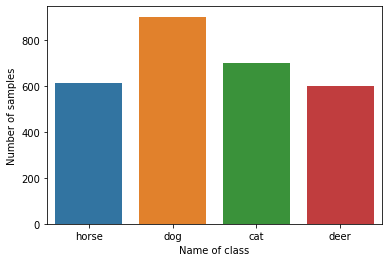

In [ ]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

Dari grafik diatas menampilkan visualisasi data dalam bentuk Bar Chart. Berdasarkan grafik tersebut menunjukkan bahwa data tertinggi dari keempat kelas dimiliki oleh kelas Dog dengan sebanyak 900 gambar, lalu kelas Cat sebanyak 700 gambar, kelas Deer dan Horse sebanyak 600 gambar.

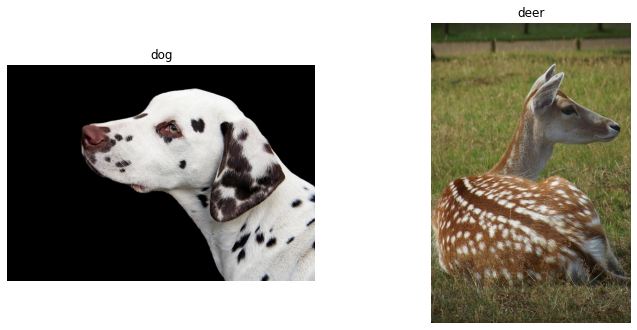

In [ ]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(32 , 32))
for x in range(2):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,5)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

Dari gambar diatas merupakan hasil prediksi random images dari train set dengan memberikan label class pada setiap gambar yang dilakukan pendeteksian gambar.

# 3. Preparing the data

In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

Dari kode diatas menggunakan keras.preprocessing.image.ImageDataGenerator class sangat penting untuk melakukan normalize data karena data akan diproses untuk improve performance secara keseluruhan. Parameter rescale digunakan untuk scale image pixel values yaitu 1./255 dengan width shift range dan height shift range yaitu 0.2. Validation split yang digunakan pada metode ImageDataGenerator adalah 0.2.

In [ ]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=32)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=32 )

Found 2248 images belonging to 4 classes.
Found 562 images belonging to 4 classes.


Dari output diatas, menunjukkan bahwa terdapat 2248 gambar dari 4 kelas pada train ds. Lalu terdapat 562 gambar dari 4 kelas pada validation ds.

# 4. Building the model

In [ ]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

17225924/17225924 [==============================] - 2s 0us/step


Untuk architecture menggunakan model MobileNet dengan input_shape (224, 224, 3)

In [ ]:

checkpoint_filepath = '/content/drive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                 2

Berdasarkan kode diatas dilakukan untuk menambahkan accuracy pada metrics yang terdapat pada model sequential dengan melakukan train model dengan categorical_crossentropy loss dan SGD optimizer yang merupakan sensible optimization algorithm karena dapat melakukan automasi learning-rate tuning. Model tersebut akan memonitor accuracy saat melakukan training.

# 5. Training and evaluating

In [ ]:
# model.load_weights(checkpoint_filepath)
# model.load_weights bisa di jalankan saat runtime google colabs ter restart

history = model.fit(train_ds , batch_size=32,  validation_data = val_ds , epochs = 30, callbacks=[model_checkpoint_callback])

Epoch 1/30
71/71 [==============================] - 1053s 15s/step - loss: 0.8527 - accuracy: 0.6837 - val_loss: 0.4388 - val_accuracy: 0.8754
Epoch 2/30
71/71 [==============================] - 51s 723ms/step - loss: 0.3329 - accuracy: 0.9044 - val_loss: 0.3105 - val_accuracy: 0.8897
Epoch 3/30
71/71 [==============================] - 52s 734ms/step - loss: 0.2308 - accuracy: 0.9306 - val_loss: 0.2131 - val_accuracy: 0.9288
Epoch 4/30
71/71 [==============================] - 52s 732ms/step - loss: 0.1747 - accuracy: 0.9488 - val_loss: 0.1963 - val_accuracy: 0.9288
Epoch 5/30
71/71 [==============================] - 52s 728ms/step - loss: 0.1452 - accuracy: 0.9573 - val_loss: 0.1858 - val_accuracy: 0.9306
Epoch 6/30
71/71 [==============================] - 52s 729ms/step - loss: 0.1297 - accuracy: 0.9595 - val_loss: 0.1778 - val_accuracy: 0.9377
Epoch 7/30
71/71 [==============================] - 51s 723ms/step - loss: 0.1046 - accuracy: 0.9684 - val_loss: 0.1601 - val_accuracy: 0.9431

18/18 [==============================] - 10s 522ms/step - loss: 0.1272 - accuracy: 0.9555


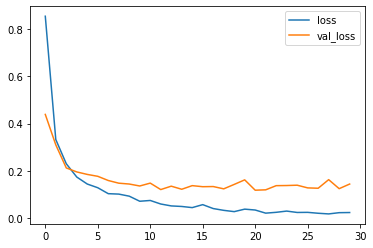

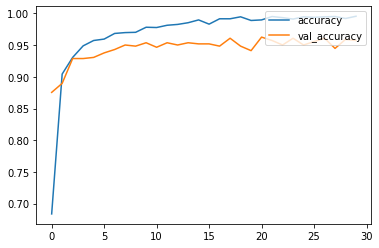

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# 6. Preparing for submission

In [ ]:
sub_csv ='/content/drive/MyDrive/ofa-ai-mastery-computer-vision/Sample_submission.csv'
path_test = '/content/drive/MyDrive/ofa-ai-mastery-computer-vision/test/test'

In [ ]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [ ]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 21ms/step


In [ ]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [ ]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)